In [334]:
#autoreload
%load_ext autoreload
%autoreload 2

import torch 
import neuralprocesses
import numpy as np

import neuralprocesses.torch as nps
import lab as B

from run_training import unpickle_object
from datasets import HydroDataset
import config as C

from torch.utils.data import DataLoader

import config as C
from architectures import SimpleConv, UNet, DepthSepConv1d
from convcnp_architectures import ConvCNP
import pickle

from datasets import HydroDataset, HydroTestDataset
from torch.utils.data import DataLoader

torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from plot_utils import plot_training_loss, plot_model_task
from task_utils import task_to_device, loaded_task
from likelihoods import compute_logpdf
from run_training import get_batch_size
from transformations import rev_transform, rev_transform_tensor, rev_standardise
import NSE
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
# cnp = nps.construct_convgnp(
#     dim_x=1,
#     dim_yc=(1,1,1,1,1),
#     dim_yt=1,
#     likelihood='',
# )

In [381]:
# dist = unpickle_object('pickled/dist.pkl')\
dist = "gaussian"
stats_dict = unpickle_object('pickled/stats_dict.pkl')

df_train = unpickle_object('pickled/train.pkl')
df_test_both = unpickle_object('pickled/test_both.pkl')
df_test_catchment = unpickle_object('pickled/test_catchment.pkl')
df_test_temporal = unpickle_object('pickled/test_temporal.pkl')
df_att = unpickle_object('pickled/df_att.pkl')

basin_means = unpickle_object('pickled/basin_means.pkl')
basin_stds = unpickle_object('pickled/basin_stds.pkl')

q_mu = stats_dict['QObs(mm/d)']['mean']
q_sigma = stats_dict['QObs(mm/d)']['std']

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(C.context_channels)-1,
                #=SimpleConv(in_channels=C.rho_in_channels),
                # rho=UNet(in_channels=C.rho_in_channels),
                rho=DepthSepConv1d(in_channels=C.rho_in_channels, conv_channels=64, num_layers=7, kernel_size=15),
                points_per_unit=C.points_per_unit,
                dynamic_feature_embedding=False,
                dynamic_embedding_dims=C.dynamic_embedding_dims,
                static_embedding_dims=C.static_embedding_dims,
                static_feature_embedding=C.static_feature_embedding,
                static_embedding_in_channels=C.static_embedding_in_channels,
                static_feature_missing_data=C.static_feature_missing_data,
                static_embedding_location=C.static_embedding_location,
                distribution=dist)

# Assign model to device
model.to(device)

# Data generator
gen_train = HydroDataset(dataframe = df_train,
                        df_att = df_att,
                        batch_size = 16,
                        num_tasks = 16,
                        channels_c = C.context_channels,
                        channels_t = C.target_channels,
                        channels_att = C.attributes,
                        channels_t_val = C.target_val_channel,
                        context_mask = C.context_mask,
                        target_mask = C.target_mask,
                        extrapolate = C.extrapolate_flag,
                        timeslice = C.timeslice,
                        dropout_rate = 0, #  0.3,
                        concat_static_features = C.concat_static_features,
                        min_train_points= C.min_train_points,
                        min_test_points= C.min_test_points,
                        max_train_points= C.max_train_points,
                        max_test_points= C.max_test_points,
                        device='cpu',
                        return_basins=True
                        )

# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,C.timeslice)[None, :, None].to(device)

# Instantiate data generator for testing.
NUM_TEST_TASKS = 16 # 128
gen_test = HydroDataset(dataframe=df_test_both,
                        df_att = df_att,
                        batch_size = 16,
                        num_tasks = NUM_TEST_TASKS,
                        channels_c = C.context_channels,
                        channels_t = C.target_channels,
                        channels_att = C.attributes,
                        channels_t_val = C.target_val_channel,
                        context_mask = C.context_mask,
                        target_mask = C.target_mask,
                        extrapolate = True,
                        concat_static_features = C.concat_static_features,
                        timeslice = 365*2, #C.timeslice,
                        min_train_points = 365,# C.min_train_points,
                        min_test_points = 365,#C.min_test_points,
                        max_train_points =365,# C.max_train_points,
                        max_test_points =365,# C.max_test_points,
                        device = 'cpu',
                        return_basins=True
                        )

In [382]:
# load state dict, and update model
# state_dict_path = r'_experiments\2024-07-25_13-10-04_forecasting-gaussian\model_best.pth.tar'
state_dict_path = r"_experiments\2024-07-25_21-22-53_forecasting-gaussian\model_best.pth.tar"
# state_dict_path = r"_experiments\2024-07-24_23-51-47_forecasting-gaussian\model_best.pth.tar"
model.load_state_dict(torch.load(state_dict_path))

<All keys matched successfully>

In [383]:
# total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 29272


In [387]:
gen_test = HydroTestDataset(dataframe=df_test_both,
                            df_att = df_att,
                            batch_size = 64,
                            num_tasks = NUM_TEST_TASKS,
                            channels_c = C.context_channels,
                            channels_t = C.target_channels,
                            channels_att = C.attributes,
                            channels_t_val = C.target_val_channel,
                            context_mask = C.context_mask,
                            target_mask = C.target_mask,
                            extrapolate = True,
                            concat_static_features = C.concat_static_features,
                            timeslice = C.timeslice,
                            min_train_points = C.min_train_points,
                            min_test_points = C.min_test_points,
                            max_train_points = C.max_train_points,
                            max_test_points = C.max_test_points,
                            device = 'cpu',
                            )

In [388]:
dataloader = DataLoader(dataset=gen_test, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():

    for idx, (task, basins) in enumerate(dataloader):
        task = loaded_task(task)

        y_means = torch.zeros_like(task['y_target'])
        y_sigmas = torch.zeros_like(task['y_target'])

        for i in range(task['x_target'].shape[1]):
            x = task['x_context'][:,i:i+364,:]
            y = task['y_context'][:,i:i+364,:]
            x_out = task['x_target'][:,i,:].unsqueeze(1)

            y_loc, y_scale = model(x = x,
                                    y = y, 
                                    x_out = x_out, 
                                    y_att = task['y_att'], 
                                    #f = task['feature'], 
                                    #m = task['m'], 
                                    static_masking_rate = 0,
                                    )        
            
            _, y_mean, y_sigma = compute_logpdf(y_loc, y_scale, task, dist=dist, return_mu_and_sigma=True)

            y_means[:,i] = y_mean.squeeze(1)
            y_sigmas[:,i] = y_sigma.squeeze(1)

            if i % 1000 == 0:
                print(i)
        
        batch_size = get_batch_size(gen_test)

        obs=rev_transform_tensor(task['y_target'],transform=C.transform, mu=q_mu,sigma=q_sigma, scaling=C.scaling).detach().cpu()
        mean_obs=rev_transform_tensor(task['y_target_val'],transform=C.transform, mu=q_mu,sigma=q_sigma, scaling=C.scaling).detach().cpu()
        sim=rev_transform_tensor(y_means, scaling=C.scaling, transform=C.transform, mu=q_mu, sigma=q_sigma, is_label=True, sigma_log=y_sigma).detach().cpu() 
        sim_sigma=rev_transform_tensor(y_sigmas, scaling=C.scaling, transform=C.transform, mu=q_mu, sigma=q_sigma, is_label=True, sigma_log=y_sigma).detach().cpu() 

        basin_stds_tensor = torch.tensor([basin_stds[basins[i][0]] for i in range(len(basins))])
        basin_mean_tensor = torch.tensor([basin_means[basins[i][0]] for i in range(len(basins))])
        
        obj_nse = NSE.nse_tensor(obs=obs,
                                 sim=sim,
                                 basin_stds=basin_stds_tensor,
                                 epsilon=0.1,
                                 reduction='none'
                                )
        
        # fig_flag = True
        # if fig_flag:
        #     fig = plt.figure(figsize=(24, 15))
        #     for i in range(3):
        #         plt.subplot(3, 1, i + 1)
        #         plot_model_task(model, task, C.timeslice, idx=i, legend=i==2, dist=dist)
        #     plt.show()
        
        print(obj_nse)
        print(obj_nse.mean(), obj_nse.median())
    	
        break
            

0
1000
2000
3000
4000
5000
tensor([-1.2182e+01, -4.2503e+00, -1.0384e+00, -1.6203e-01, -3.8053e-01,
        -1.2353e+00, -3.8053e-01, -1.2353e+00, -1.5853e+00, -4.0535e-01,
        -1.2182e+01, -3.8053e-01, -9.7522e+00, -8.6970e-01, -1.5853e+00,
        -1.5113e-01, -1.5113e-01, -4.0801e+00, -3.8053e-01, -9.0659e-01,
        -8.9086e+00, -1.0035e+00, -1.9358e+00, -4.2614e-01, -2.0447e-01,
        -1.9358e+00, -4.2614e-01, -4.0801e+00, -2.0447e-01, -2.8732e+00,
        -3.8053e-01, -1.0002e+00, -1.5585e+00, -1.5585e+00, -1.2353e+00,
        -1.2862e+01, -3.5080e-01, -1.8282e+00, -3.2039e+00, -3.5080e-01,
        -1.6203e-01, -1.2353e+00, -2.0164e+00, -9.0659e-01, -1.4098e+00,
        -4.0535e-01, -8.6970e-01, -1.2862e+01, -1.0416e+00, -1.0035e+00,
        -3.5080e-01, -1.3397e+02, -1.1073e+00, -3.8053e-01, -4.2614e-01,
        -1.3071e-01, -1.9358e+00, -4.0801e+00, -2.6102e+00, -2.6102e+00,
        -8.9086e+00, -4.5573e+00, -1.2182e+01, -4.2561e-02])
tensor(-4.6066) tensor(-1.2353)


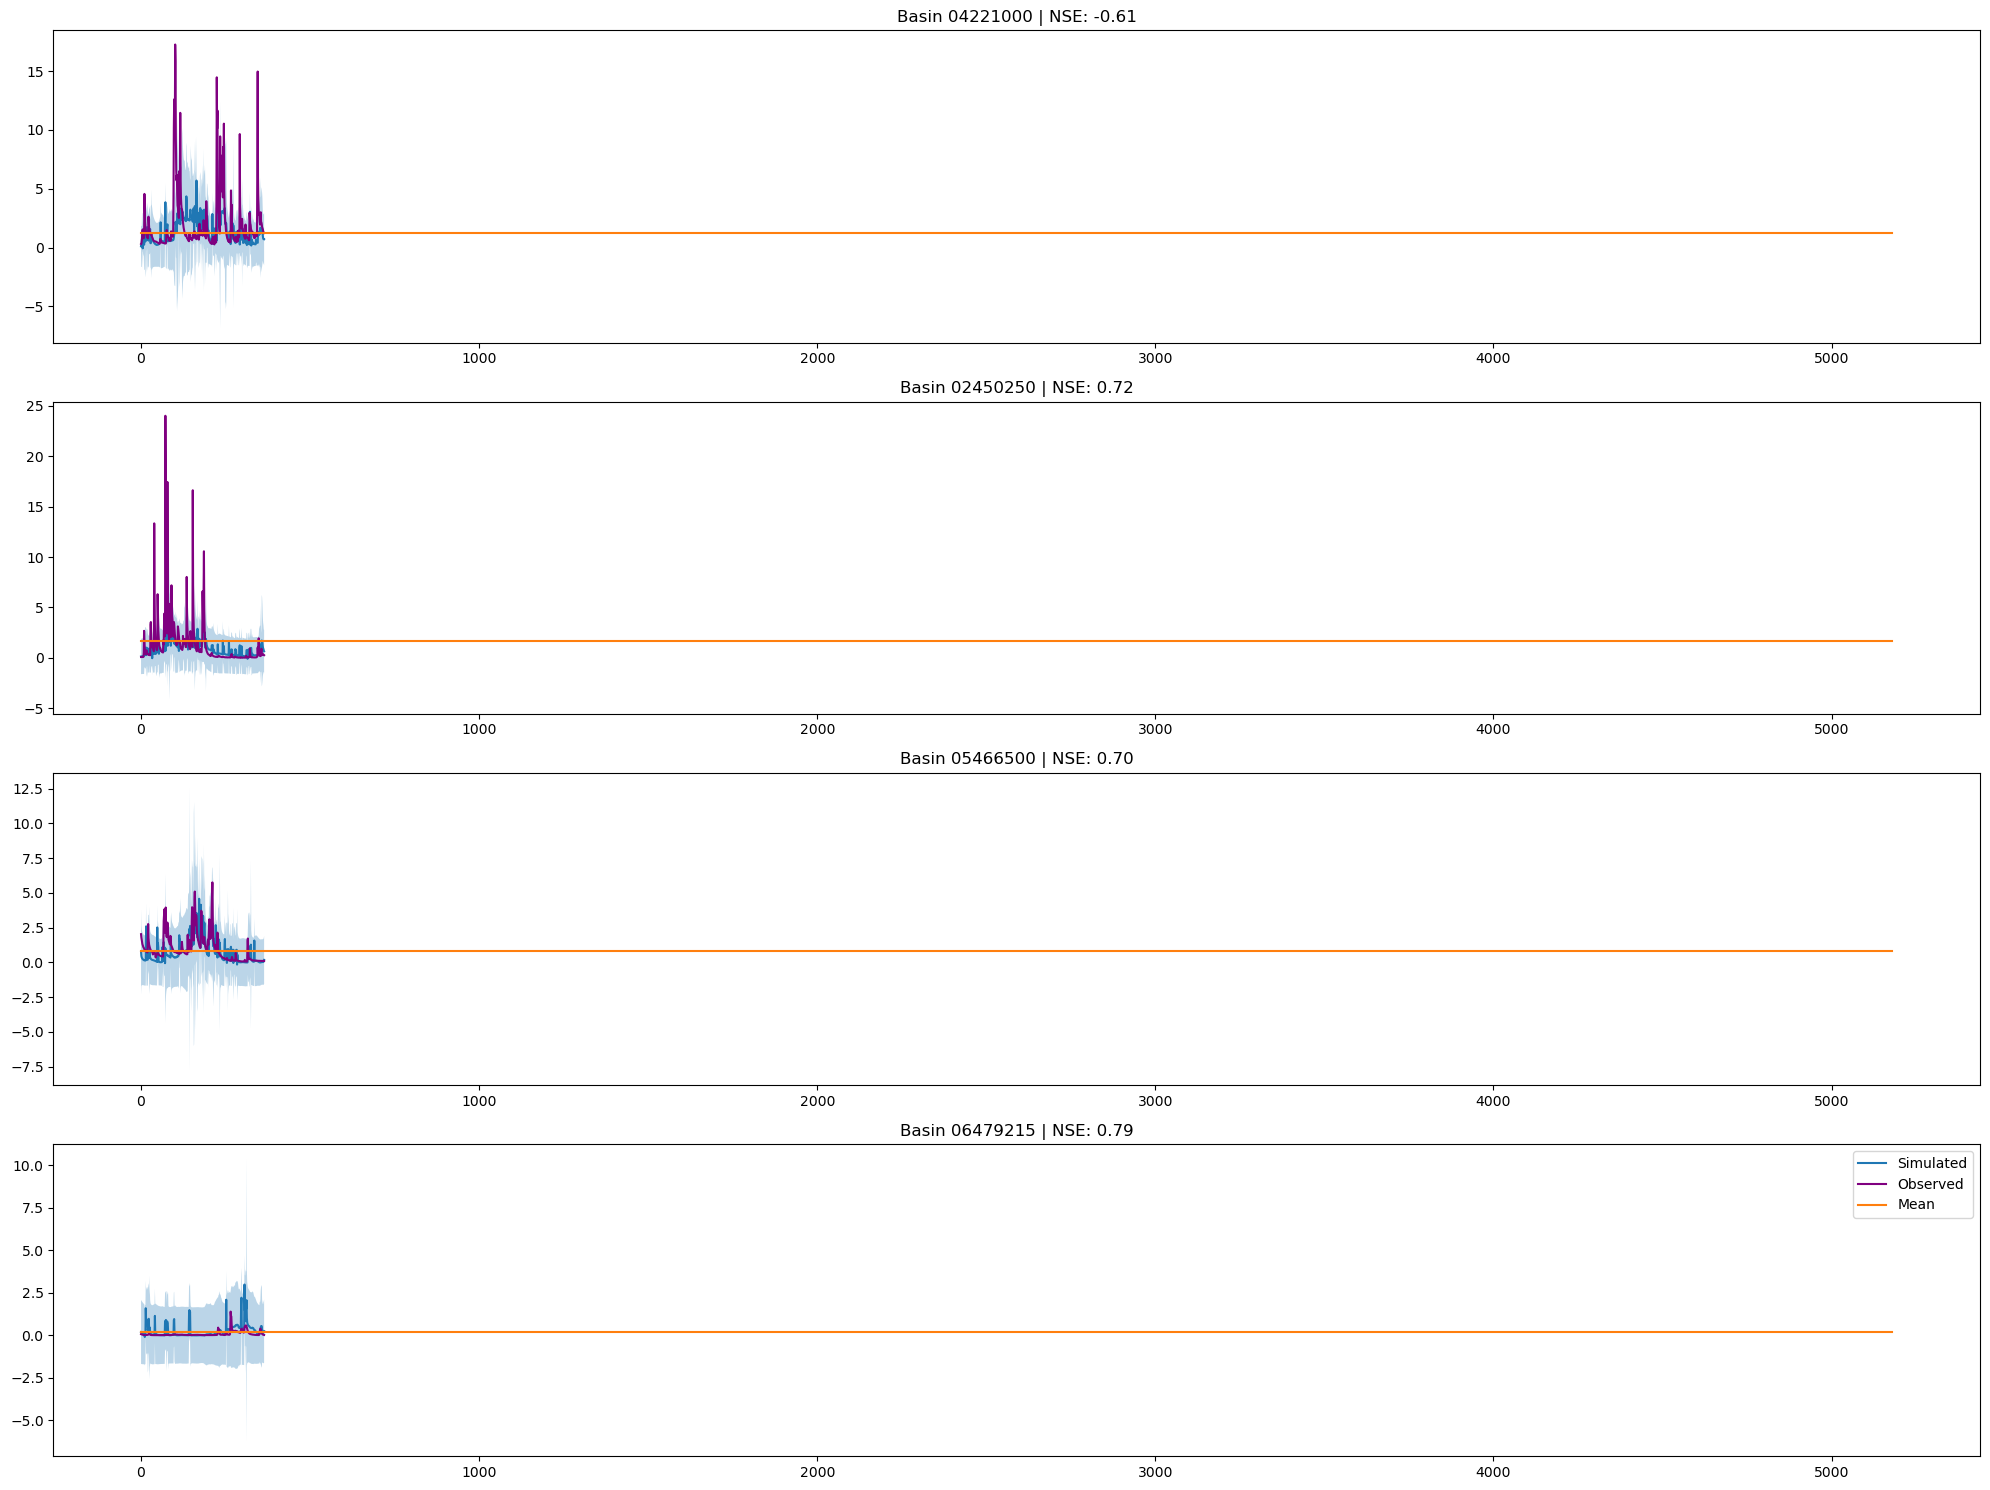

In [385]:
fig, axes = plt.subplots(4,1, figsize=(20,15))
for idx, ax in enumerate(axes.flatten()):    
    o = obs[idx].flatten().numpy()
    s = sim[idx].flatten().numpy()
    s_sigma = sim_sigma[idx].flatten().numpy()
    ax.plot(s, label='Simulated')
    ax.plot(o, 'purple', label='Observed',)
    
    ax.plot([0, 5180], [basin_mean_tensor[idx].numpy(),basin_mean_tensor[idx].numpy()], label='Mean')
    ax.title.set_text(f'Basin {basins[idx][0]} | NSE: {obj_nse[idx]:.2f}')
    ax.fill_between(np.arange(len(s)), s-s_sigma, s+s_sigma, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [372]:
dataloader = DataLoader(dataset=gen_test, batch_size=1, shuffle=False)

model.eval()

with torch.no_grad():

    for idx, (task, basins) in enumerate(dataloader):
        task = loaded_task(task)

        # y_means = torch.zeros_like(task['y_target'])
        # y_sigmas = torch.zeros_like(task['y_target'])

        # for i in range(task['x_target'].shape[1]):
        x = task['x_context']#[:,i:i+364,:]
        y = task['y_context']#[:,i:i+364,:]
        x_out = task['x_target']#[:,i,:].unsqueeze(1)

        y_loc, y_scale = model(x = x,
                                y = y, 
                                x_out = x_out, 
                                y_att = task['y_att'], 
                                #f = task['feature'], 
                                #m = task['m'], 
                                static_masking_rate = 0,
                                )        
        
        _, y_mean, y_sigma = compute_logpdf(y_loc, y_scale, task, dist=dist, return_mu_and_sigma=True)

            # y_means[:,i] = y_mean.squeeze(1)
            # y_sigmas[:,i] = y_sigma.squeeze(1)
        
        batch_size = get_batch_size(gen_test)

        obs=rev_transform_tensor(task['y_target'],transform=C.transform, mu=q_mu,sigma=q_sigma, scaling=C.scaling).detach().cpu()
        mean_obs=rev_transform_tensor(task['y_target_val'],transform=C.transform, mu=q_mu,sigma=q_sigma, scaling=C.scaling).detach().cpu()
        sim=rev_transform_tensor(y_mean, scaling=C.scaling, transform=C.transform, mu=q_mu, sigma=q_sigma, is_label=True, sigma_log=y_sigma).detach().cpu() 
        sim_sigma=rev_transform_tensor(y_sigma, scaling=C.scaling, transform=C.transform, mu=q_mu, sigma=q_sigma, is_label=True, sigma_log=y_sigma).detach().cpu() 

        basin_stds_tensor = torch.tensor([basin_stds[basins[i][0]] for i in range(len(basins))])
        basin_mean_tensor = torch.tensor([basin_means[basins[i][0]] for i in range(len(basins))])
        
        obj_nse = NSE.nse_tensor(obs=obs,
                                 sim=sim,
                                 basin_stds=basin_stds_tensor,
                                 epsilon=0.1,
                                 reduction='none'
                                )
        
        # fig_flag = True
        # if fig_flag:
        #     fig = plt.figure(figsize=(24, 15))
        #     for i in range(3):
        #         plt.subplot(3, 1, i + 1)
        #         plot_model_task(model, task, C.timeslice, idx=i, legend=i==2, dist=dist)
        #     plt.show()
        
        print(obj_nse)
        print(obj_nse.mean(), obj_nse.median())
    	
        break
            

tensor([-5.8058e+02, -9.4976e-01, -1.3781e+02, -5.5706e+00, -9.8028e-01,
        -2.0737e+01, -8.3333e-03, -8.5807e+00, -4.0306e+02, -1.2593e+00,
        -3.8420e+02, -6.4254e+01, -7.8660e+00, -4.5510e+00, -7.3859e+02,
        -6.6665e+00])
tensor(-147.8545) tensor(-8.5807)


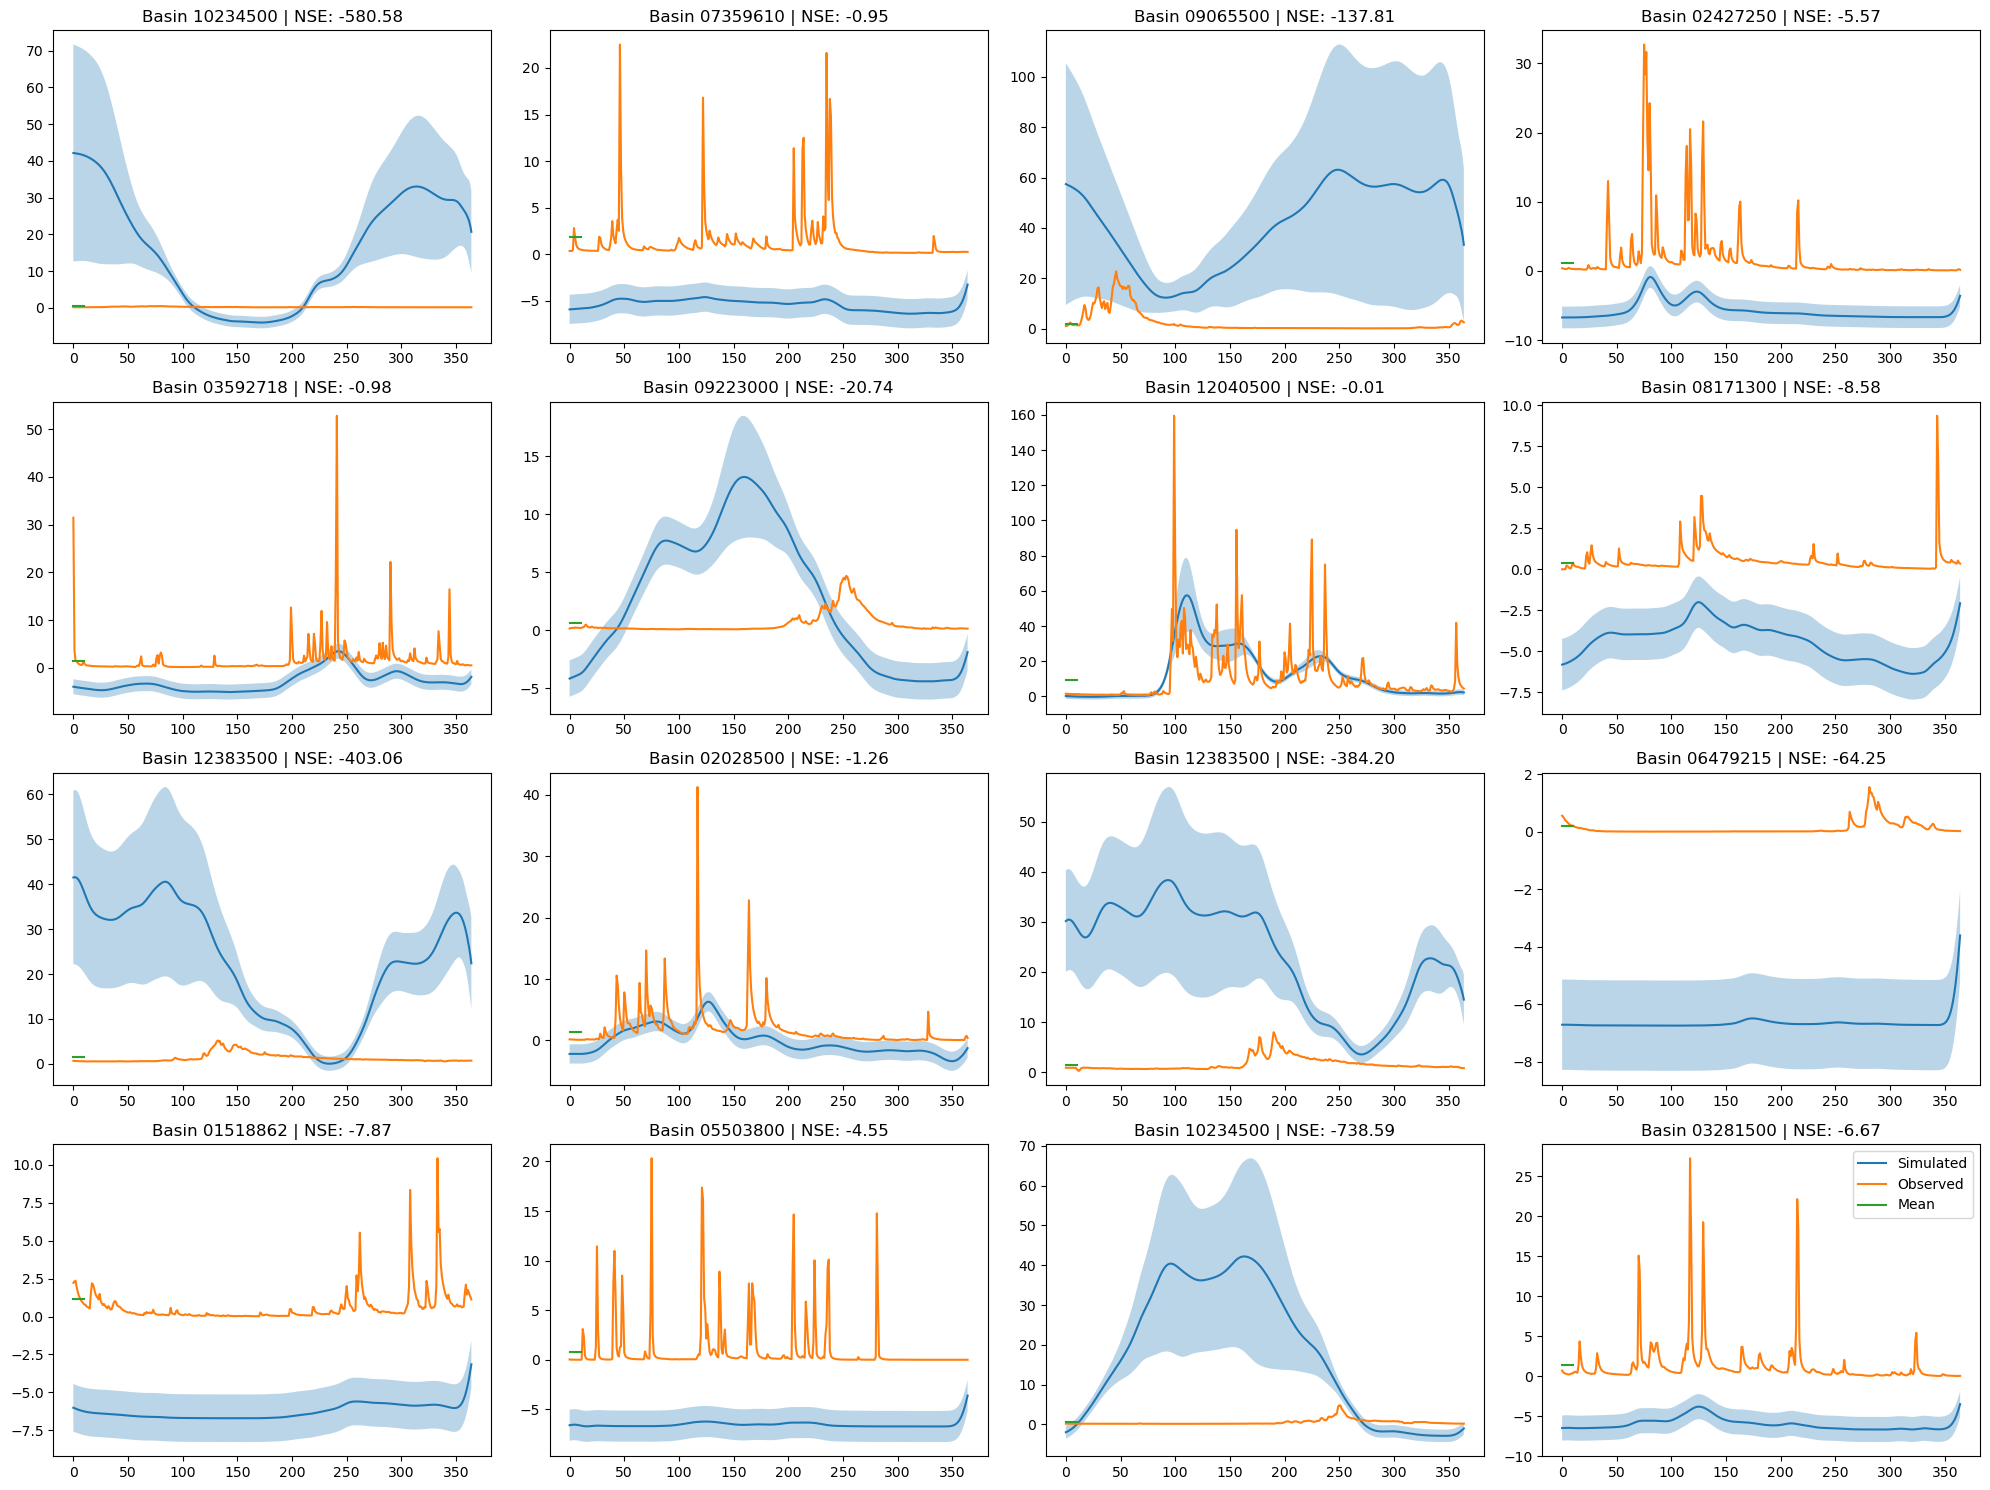

In [373]:
fig, axes = plt.subplots(4,4, figsize=(20,15))
for idx, ax in enumerate(axes.flatten()):    
    o = obs[idx].flatten().numpy()
    s = sim[idx].flatten().numpy()
    s_sigma = sim_sigma[idx].flatten().numpy()
    ax.plot(s, label='Simulated')
    ax.plot(o, label='Observed',)
    
    ax.plot([0, 10], [basin_mean_tensor[idx].numpy(),basin_mean_tensor[idx].numpy()], label='Mean')
    ax.title.set_text(f'Basin {basins[idx][0]} | NSE: {obj_nse[idx]:.2f}')
    ax.fill_between(np.arange(len(s)), s-s_sigma, s+s_sigma, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()